# Testes de Exploração (LinUCB vs Random)

Este notebook simula um cenário sintético de bandido contextual comparando a política LinUCB com uma política aleatória. 
- Gera recompensas binárias a partir de parâmetros ocultos dos braços
- Roda múltiplos passos e runs para calcular métricas agregadas (reward médio, regret instantâneo e cumulativo).
- Plota curvas de desempenho por passo e apresenta um resumo no último step.


## 1. Setup

In [ ]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from app.core.recommender import LinUCBRecommender


def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


## 2. Random Context Test

In [ ]:
def run_linucb_simulation(
    alpha: float,
    n_arms: int = 20,
    d: int = 8,
    n_steps: int = 1000,
    n_runs: int = 10,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Small synthetic simulation for LinUCB.

    Returns a DataFrame with averages by step (reward, cumulative reward, regret, cumulative regret).
    """
    rng = np.random.default_rng(random_state)
    records = []

    for run in range(n_runs):
        # "True" environment parameters for each arm
        true_thetas = rng.normal(0, 1, size=(n_arms, d))

        # LinUCB agent
        agent = LinUCBRecommender(n_arms=n_arms, d=d, alpha=alpha)

        cum_reward = 0.0
        cum_regret = 0.0

        for t in range(1, n_steps + 1):
            # Contexts per arm (different for each step)
            contexts = rng.normal(0, 1, size=(n_arms, d))

            logits = np.sum(true_thetas * contexts, axis=1)
            probs = sigmoid(logits)

            # Best arm in this step
            best_arm = int(np.argmax(probs))
            best_p = float(probs[best_arm])

            # LinUCB chosen Arm
            candidate_arms: List[int] = list(range(n_arms))
            chosen_arm = agent.recommend(
                candidate_arms=candidate_arms,
                contexts=contexts,
                n_recommendations=1,
            )[0]

            chosen_p = float(probs[chosen_arm])

            reward = rng.binomial(1, chosen_p)

            agent.update(contexts[chosen_arm], chosen_arm, reward)

            # Updates cumulative metrics
            cum_reward += reward
            instant_regret = best_p - chosen_p
            cum_regret += instant_regret

            records.append(
                {
                    "run": run,
                    "step": t,
                    "policy": f"linucb_alpha_{alpha}",
                    "alpha": alpha,
                    "reward": reward,
                    "cum_reward": cum_reward,
                    "instant_regret": instant_regret,
                    "cum_regret": cum_regret,
                }
            )

    df = pd.DataFrame(records)
    agg = (
        df.groupby(["policy", "alpha", "step"])
        .agg(
            reward_mean=("reward", "mean"),
            cum_reward_mean=("cum_reward", "mean"),
            instant_regret_mean=("instant_regret", "mean"),
            cum_regret_mean=("cum_regret", "mean"),
        )
        .reset_index()
    )
    return agg


## 3. Analyze Exploration Distribution

In [ ]:
def run_random_simulation(
    n_arms: int = 20,
    d: int = 8,
    n_steps: int = 1000,
    n_runs: int = 10,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Synthetic simulation for random policy (chooses random arm).
    Uses the same type of environment as LinUCB.
    """
    rng = np.random.default_rng(random_state)
    records = []

    for run in range(n_runs):
        true_thetas = rng.normal(0, 1, size=(n_arms, d))

        cum_reward = 0.0
        cum_regret = 0.0

        for t in range(1, n_steps + 1):
            contexts = rng.normal(0, 1, size=(n_arms, d))

            logits = np.sum(true_thetas * contexts, axis=1)
            probs = sigmoid(logits)

            best_arm = int(np.argmax(probs))
            best_p = float(probs[best_arm])

            chosen_arm = rng.integers(0, n_arms)
            chosen_p = float(probs[chosen_arm])

            reward = rng.binomial(1, chosen_p)

            cum_reward += reward
            instant_regret = best_p - chosen_p
            cum_regret += instant_regret

            records.append(
                {
                    "run": run,
                    "step": t,
                    "policy": "random",
                    "alpha": np.nan,
                    "reward": reward,
                    "cum_reward": cum_reward,
                    "instant_regret": instant_regret,
                    "cum_regret": cum_regret,
                }
            )

    df = pd.DataFrame(records)
    agg = (
        df.groupby(["policy", "step"])
        .agg(
            reward_mean=("reward", "mean"),
            cum_reward_mean=("cum_reward", "mean"),
            instant_regret_mean=("instant_regret", "mean"),
            cum_regret_mean=("cum_regret", "mean"),
        )
        .reset_index()
    )
    return agg


In [ ]:
# Synthetic scenario configuration
N_ARMS = 20
D = 8
N_STEPS = 1000
N_RUNS = 10

alphas = [0.1, 0.25, 0.5, 0.75, 1]

all_results = []

# Random
print("Rodando policy: random")
res_random = run_random_simulation(
    n_arms=N_ARMS,
    d=D,
    n_steps=N_STEPS,
    n_runs=N_RUNS,
    random_state=42,
)
all_results.append(res_random)

# LinUCB with different alphas
for a in alphas:
    print(f"Rodando LinUCB com alpha={a}")
    res_lin = run_linucb_simulation(
        alpha=a,
        n_arms=N_ARMS,
        d=D,
        n_steps=N_STEPS,
        n_runs=N_RUNS,
        random_state=42,
    )
    all_results.append(res_lin)

results = pd.concat(all_results, ignore_index=True)
results.head()


Rodando policy: random
Rodando LinUCB com alpha=0.1
Rodando LinUCB com alpha=0.25
Rodando LinUCB com alpha=0.5
Rodando LinUCB com alpha=0.75
Rodando LinUCB com alpha=1


,policy,step,reward_mean,cum_reward_mean,instant_regret_mean,cum_regret_mean,alpha
0,random,1,0.5,0.5,0.528093,0.528093,NaN
1,random,2,0.4,0.9,0.612917,1.141011,NaN
2,random,3,0.6,1.5,0.472245,1.613256,NaN
3,random,4,0.7,2.2,0.302611,1.915866,NaN
4,random,5,0.6,2.8,0.474379,2.390246,NaN


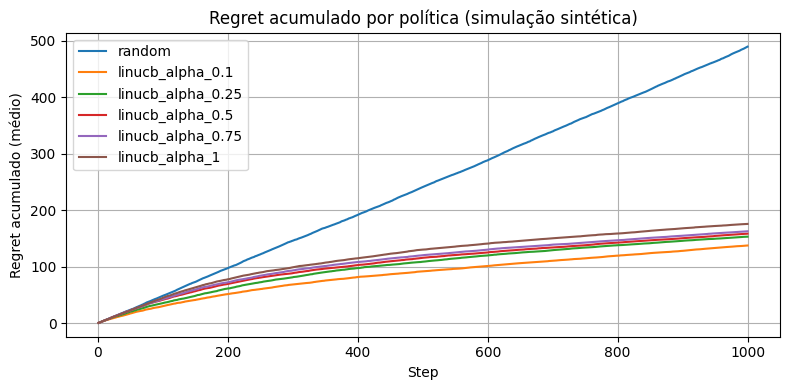

In [17]:
def plot_cum_regret(results: pd.DataFrame):
    plt.figure(figsize=(8, 4))
    policies = results["policy"].unique()

    for policy in policies:
        sub = results[results["policy"] == policy]
        plt.plot(sub["step"], sub["cum_regret_mean"], label=policy)

    plt.xlabel("Step")
    plt.ylabel("Regret acumulado (médio)")
    plt.title("Regret acumulado por política (simulação sintética)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_cum_regret(results)


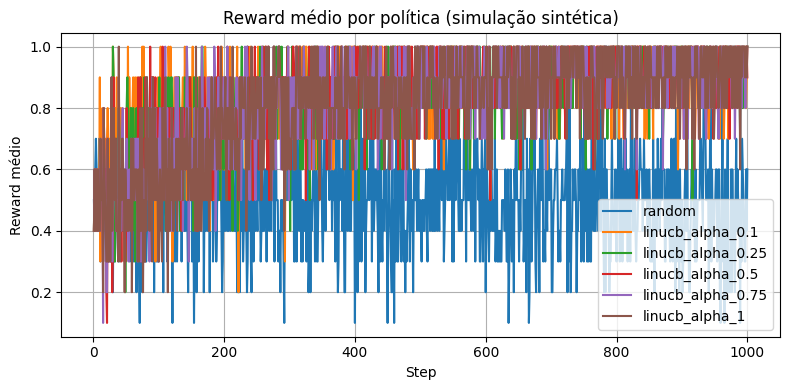

In [18]:
def plot_reward_mean(results: pd.DataFrame):
    plt.figure(figsize=(8, 4))
    policies = results["policy"].unique()

    for policy in policies:
        sub = results[results["policy"] == policy]
        plt.plot(sub["step"], sub["reward_mean"], label=policy)

    plt.xlabel("Step")
    plt.ylabel("Reward médio")
    plt.title("Reward médio por política (simulação sintética)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_reward_mean(results)


In [19]:
last_step = results["step"].max()

summary = (
    results[results["step"] == last_step]
    .groupby("policy", dropna=False)
    .agg(
        final_reward_mean=("reward_mean", "mean"),
        final_cum_regret_mean=("cum_regret_mean", "mean"),
    )
    .reset_index()
    .sort_values("final_cum_regret_mean")
)

summary


,policy,final_reward_mean,final_cum_regret_mean
0,linucb_alpha_0.1,1.0,137.459232
1,linucb_alpha_0.25,1.0,153.070659
2,linucb_alpha_0.5,0.9,158.395948
3,linucb_alpha_0.75,1.0,162.616930
4,linucb_alpha_1,1.0,175.631206
5,random,0.6,489.219967
